#### **Full Spectrum Plotting**

This notebook creates a spectrum from the 

In [1]:
import pandas as pd
import pyopenms as oms

In [2]:
%load_ext autoreload
%autoreload 2

import time
import pandas as pd
from scipy.signal import savgol_filter
from bokeh.io import output_notebook, show
import matplotlib.pyplot as plt

output_notebook()

# set global plotting backend for pandas
pd.options.plotting.backend = "ms_matplotlib" # one of: "ms_bokeh" "ms_matplotlib" "ms_plotly"
pd.set_option('display.width',500)

if pd.options.plotting.backend in ["ms_matplotlib", "ms_bokeh"]:
    title_font_size = 18
    xaxis_label_font_size = 14
    yaxis_label_font_size = 14
    xaxis_tick_font_size = 14
    yaxis_tick_font_size = 14
    annotation_font_size = 13
else:
    title_font_size = 28
    xaxis_label_font_size = 26
    yaxis_label_font_size = 26
    xaxis_tick_font_size = 24
    yaxis_tick_font_size = 24
    annotation_font_size = 24

Loading BokehJS ...

In [3]:
# # # Download test file
# import requests

# url = 'https://raw.githubusercontent.com/Roestlab/massdash/dev/test/test_data/featureMap/ionMobilityTestFeatureDfEntireSpectra.tsv'
# file_name = 'ionMobilityTestFeatureDfEntireSpectra.tsv'

# # Send a GET request to the URL
# response = requests.get(url)

# # # Save the content of the response to a file
# with open(file_name, 'wb') as file:
#     file.write(response.content)

# print(f'File {file_name} downloaded successfully!')

# url = 'https://raw.githubusercontent.com/Roestlab/massdash/dev/test/test_data/featureMap/ionMobilityTestFeatureDf.tsv'
# file_name = 'ionMobilityTestFeatureDf.tsv'

# # Send a GET request to the URL
# response = requests.get(url)

# # # Save the content of the response to a file
# with open(file_name, 'wb') as file:
#     file.write(response.content)

# print(f'File {file_name} downloaded successfully!')

In [4]:
df_ms_experiment_all = pd.read_csv("./ionMobilityTestFeatureDfEntireSpectra.tsv", sep="\t")
df_ms_experiment_all = df_ms_experiment_all[(df_ms_experiment_all['ms_level'] == 2) & (df_ms_experiment_all['rt'].between(6243.034, 6243.035))].drop(columns=['Annotation', 'product_mz', 'native_id', 'precursor_mz', 'rt', 'ms_level'])

df_ms_experiment_extracted = pd.read_csv("./ionMobilityTestFeatureDf.tsv", sep='\t')

df_ms_experiment = df_ms_experiment_all.merge(df_ms_experiment_extracted, how='left')

In [5]:
### 
# print(df_ms_experiment.head())

peptide = "AFVDFLSDEIK"
charge = 2

seq = oms.AASequence.fromString(peptide)

ion_annotations = ['prec', 'y4^1', 'y5^1', 'y6^1', 'y7^1', 'y8^1', 'y9^1']
ion_ordinals = [4, 5, 6, 7, 8, 9]

print("=" * 35)
print("precursor mz:", round(seq.getMZ(charge), 4))

ion_formula = [peptide]
ion_mz = [round(seq.getMZ(charge), 4)]
for ion in ion_ordinals:
    suffix = seq.getSuffix(ion) 
    # print(f"y{ion} ion sequence: {suffix}")
    y3_formula = suffix.getFormula(oms.Residue.ResidueType.YIon, 1)  # y3++ ion
    # print(f"y{ion} mz: {round(suffix.getMZ(1), 4)}")
    ion_formula.append(suffix)
    ion_mz.append(round(suffix.getMZ(1), 4))
annotation_df = pd.DataFrame({'Annotation':ion_annotations, 'product_mz':ion_mz, 'sequence':ion_formula})
print(annotation_df)

df = pd.merge(df_ms_experiment[['ms_level', 'mz', 'rt', 'im', 'int', 'precursor_mz', 'product_mz', 'Annotation']], annotation_df, on=['Annotation', 'product_mz'], how='left')
# # df['sequence'] = peptide
# #/ df['precursor_charge'] = charge
df.rename(columns={'Annotation':'ion_annotation'}, inplace=True)

precursor mz: 642.3295
  Annotation  product_mz     sequence
0       prec    642.3295  AFVDFLSDEIK
1       y4^1    504.2664         DEIK
2       y5^1    591.2984        SDEIK
3       y6^1    704.3825       LSDEIK
4       y7^1    851.4509      FLSDEIK
5       y8^1    966.4779     DFLSDEIK
6       y9^1   1065.5463    VDFLSDEIK


In [6]:
df.dropna()['ion_annotation'].drop_duplicates()

11279    y4^1
17668    y5^1
23308    y6^1
27790    y7^1
30723    y8^1
33529    y9^1
Name: ion_annotation, dtype: object

In [7]:
df = df.fillna('')
df['sequence'] = df['sequence'].astype(str)

In [8]:
df_new = df[['mz', 'ion_annotation', 'int']].groupby(['mz', 'ion_annotation']).sum().reset_index()

In [9]:
params_list = [
    {'title':'Spectrum (Raw)', 'bin_peaks':False},
    {'title':'Spectrum (agg: sum | bin: freedman)', 'bin_peaks':'auto', 'bin_method':'freedman-diaconis', 'aggregation_method':"sum"},
    {'title':'Spectrum (agg: mean | bin: freedman)', 'bin_peaks':'auto', 'bin_method':'freedman-diaconis', 'aggregation_method':"mean"},
    {'title':'Spectrum (agg: sum | bin: mz-tol-bin=1)', 'bin_peaks':'auto', 'bin_method':'mz-tol-bin', 'mz_tol':1, 'aggregation_method':"sum"},
    {'title':'Spectrum (agg: mean | bin: mz-tol-bin=1)', 'bin_peaks':'auto', 'bin_method':'mz-tol-bin', 'mz_tol':1, 'aggregation_method':"mean"},
    {'title':'Spectrum (agg: max | bin: mz-tol-bin=1)', 'bin_peaks':'auto', 'bin_method':'mz-tol-bin', 'mz_tol':1, 'aggregation_method':"max"},
    {'title':'Spectrum (agg: max | bin: mz-tol-bin=1pct-diff)', 'bin_peaks':'auto', 'bin_method':'mz-tol-bin', 'mz_tol':'1pct-diff', 'aggregation_method':"max"},
    {'title':'Spectrum (agg: max | bin: mz-tol-bin=1pct-diff)', 'bin_peaks':'auto', 'bin_method':'mz-tol-bin', 'mz_tol':'1pct-diff', 'aggregation_method':"max", "ion_annotation":"ion_annotation"},
]

# Create a 3-row subplot
fig, axs = plt.subplots(4, 2, figsize=(14, 14))

# Close the figure to suppress initial empty display
plt.close()

In [10]:
p_list = []
i = j = 0
for params in params_list:
    print("-"*100)
    print(f"Params: {params}")
    start_time = time.time()
    p = df_new.plot(kind="spectrum", x="mz", y="int", 
            fig=axs[i][j],
            annotate_mz=False, grid=False, 
            title_font_size = title_font_size,
            xaxis_label_font_size = xaxis_label_font_size,
            yaxis_label_font_size = yaxis_label_font_size,
            xaxis_tick_font_size = xaxis_tick_font_size,
            yaxis_tick_font_size = yaxis_tick_font_size,
            annotation_font_size = annotation_font_size,
            **params
            )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Execution time: {elapsed_time:.6f} seconds')
    p.fig.set_title(f"{params['title']}\nexec_time={elapsed_time:.2f}s")
    p_list.append(p)
    j += 1
    if j >= 2:  # If we've filled two columns, move to the next row
        j = 0
        i += 1  
fig.tight_layout()

----------------------------------------------------------------------------------------------------
Params: {'title': 'Spectrum (Raw)', 'bin_peaks': False}
Execution time: 5.852855 seconds
----------------------------------------------------------------------------------------------------
Params: {'title': 'Spectrum (agg: sum | bin: freedman)', 'bin_peaks': 'auto', 'bin_method': 'freedman-diaconis', 'aggregation_method': 'sum'}
Execution time: 0.026518 seconds
----------------------------------------------------------------------------------------------------
Params: {'title': 'Spectrum (agg: mean | bin: freedman)', 'bin_peaks': 'auto', 'bin_method': 'freedman-diaconis', 'aggregation_method': 'mean'}
Execution time: 0.025118 seconds
----------------------------------------------------------------------------------------------------
Params: {'title': 'Spectrum (agg: sum | bin: mz-tol-bin=1)', 'bin_peaks': 'auto', 'bin_method': 'mz-tol-bin', 'mz_tol': 1, 'aggregation_method': 'sum'}
Exe

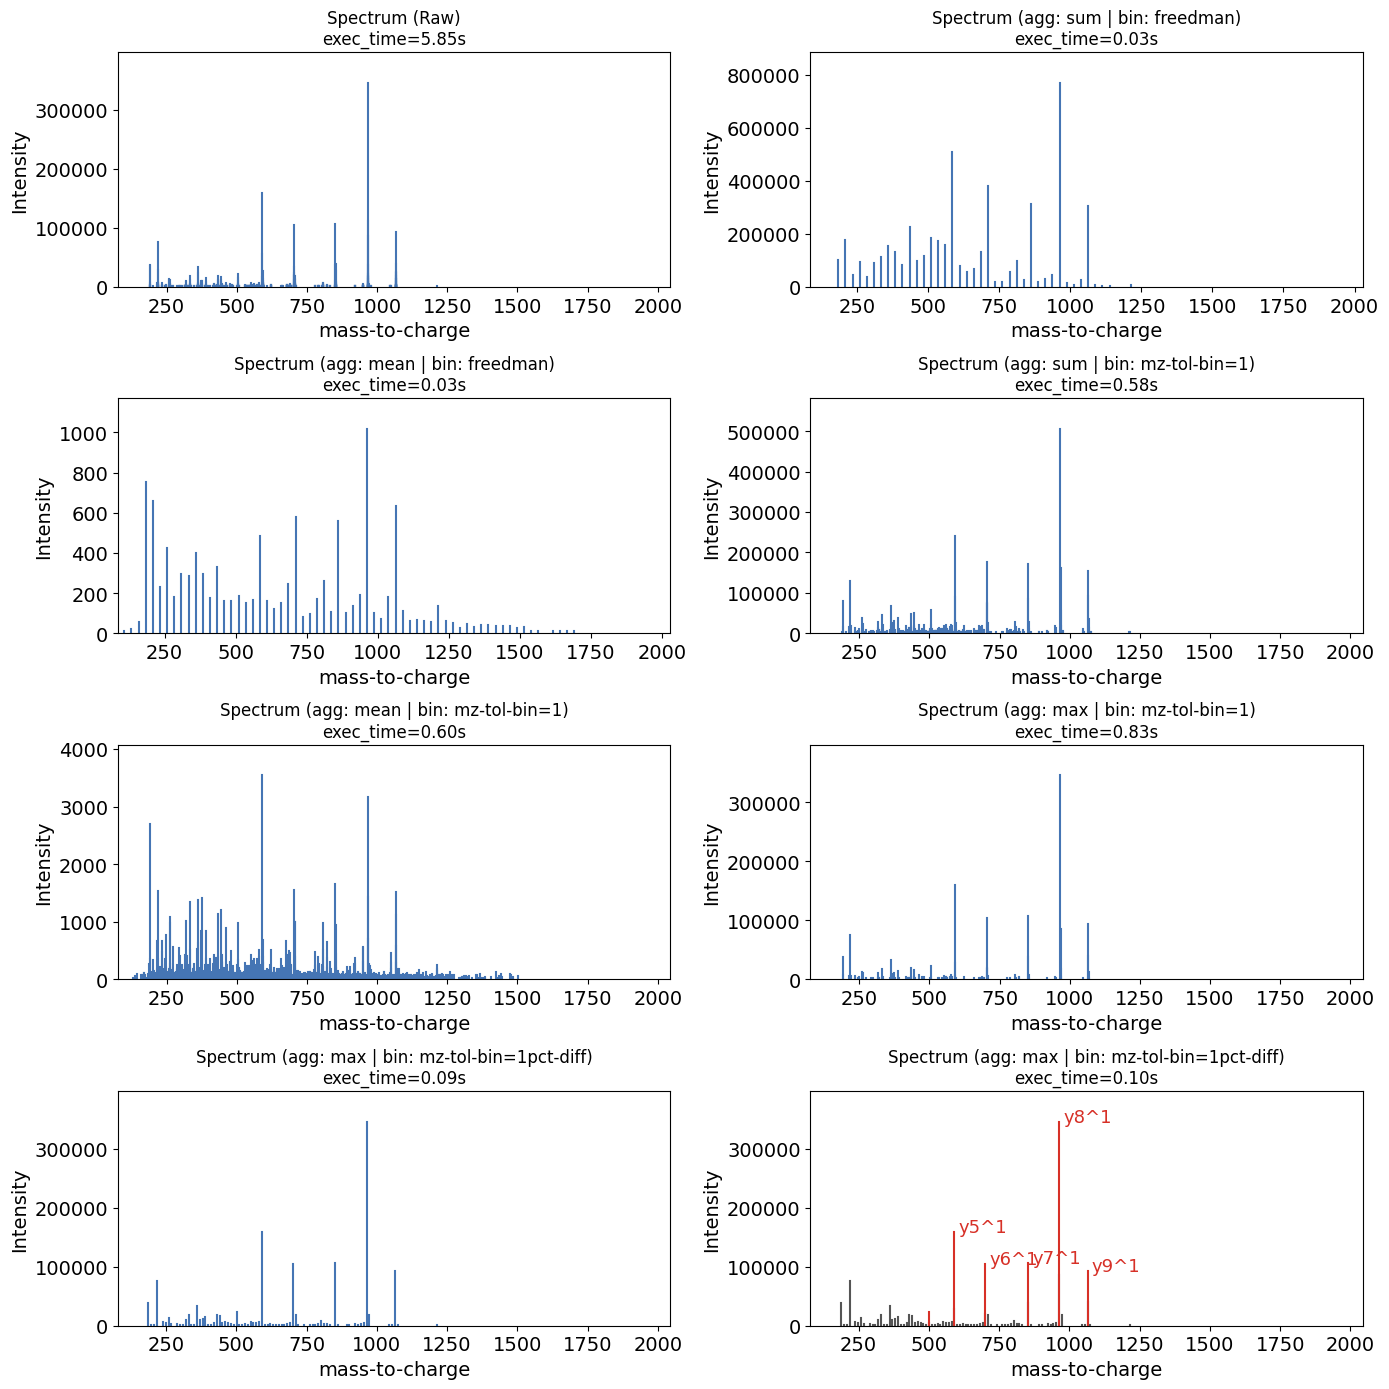

In [11]:
fig

In [12]:
df_new = df[['mz', 'ion_annotation', 'sequence', 'int']].groupby(['mz', 'ion_annotation', 'sequence']).sum().reset_index()

Params: {'bin_peaks': 'auto', 'bin_method': 'mz-tol-bin', 'mz_tol': '1pct-diff', 'aggregation_method': 'max', 'ion_annotation': 'ion_annotation'}


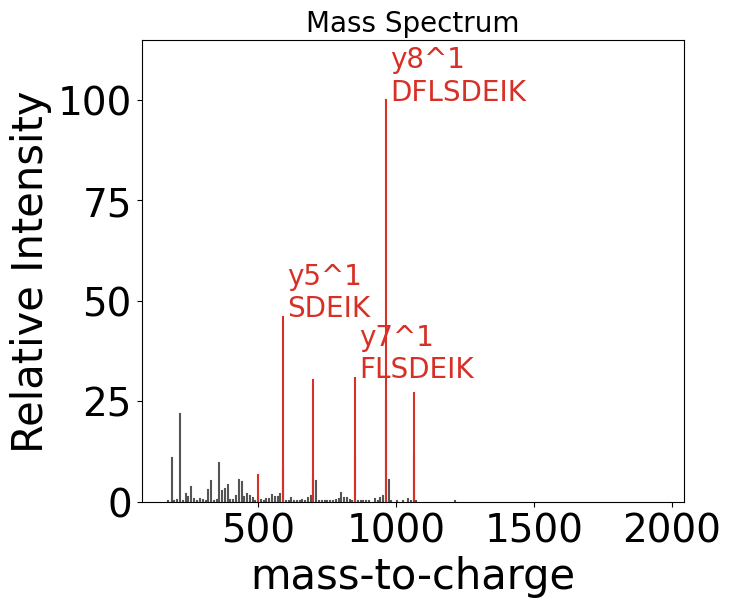

In [20]:
params = {'bin_peaks':'auto', 
          'bin_method':'mz-tol-bin', 
          'mz_tol':'1pct-diff', 
          'aggregation_method':"max", 
          "ion_annotation":"ion_annotation"}
print(f"Params: {params}")
p = df_new.plot(kind="spectrum", x="mz", y="int", 
            sequence_annotation="sequence", 
                ylabel='Relative Intensity',
            annotate_mz=False, grid=False, width=700, height=600,
                annotate_top_n_peaks=3,
                relative_intensity=True,
            title_font_size = 20,
            xaxis_label_font_size = 30,
            yaxis_label_font_size = 30,
            xaxis_tick_font_size = 28,
            yaxis_tick_font_size = 28,
            annotation_font_size = 20,
            **params,
                # backend="ms_bokeh"
            )
p.fig.set_xlim(98, 1300)
p.superFig.tight_layout()
p.superFig.savefig(f"full_spectrum_matplotlib.png")